# Fraud Detection Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
# from config import db_config

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Project/creditcard.csv')
df.shape

(284807, 31)

# 1. Preprocessing

## 1.1 Handle Missing Values

In [3]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [4]:
df.dropna(inplace=True)

## 1.2 Normalisasi Jumlah Transaksi

In [5]:
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])

## 1.3 Handling Imbalance (SMOTE)

In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

# SMOTE oversampling pada train set saja
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After  SMOTE:", y_train_res.value_counts(normalize=True))

Before SMOTE: Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
After  SMOTE: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


# 2. Exploratory Data Analysis (EDA)

## 2.1 Distribusi Fraud vs Normal

<ipython-input-7-451256334>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='pastel')


Text(0.5, 1.0, 'Distribution of Transactions (0=Normal, 1=Fraud)')

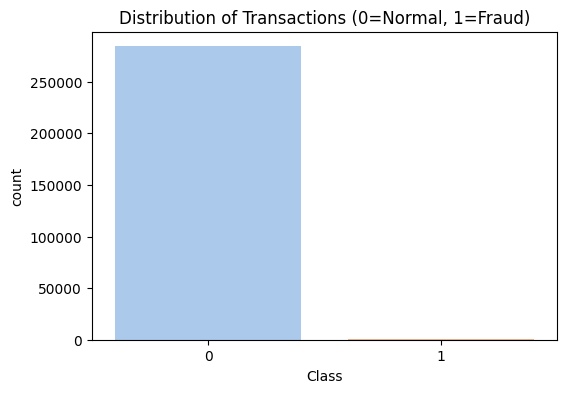

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette='pastel')
plt.title('Distribution of Transactions (0=Normal, 1=Fraud)')

## 2.2 Waktu Kejadian Fraud

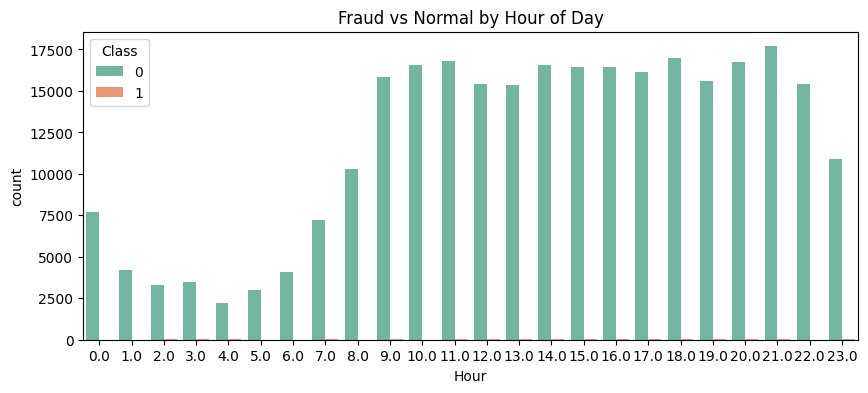

In [8]:
# Bikin kolom jam dari detik
df['Hour'] = (df['Time'] // 3600) % 24
df['Hour'] = df['Hour'].astype(int)

plt.figure(figsize=(10,4))
sns.countplot(x='Hour', hue='Class', data=df, palette='Set2')
plt.title('Fraud vs Normal by Hour of Day')
plt.legend(title='Class')

## 2.3 Fitur Paling Membedakan Fraud vs Non‑Fraud

Text(0, 0.5, 'Feature')

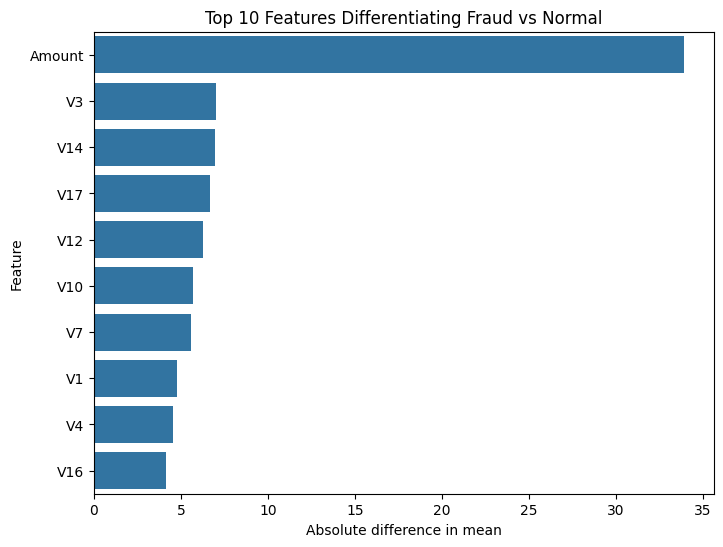

In [21]:
# Hitung mean per fitur untuk fraud dan normal
# Drop kolom 'Time' sebelum menghitung mean per kelas
df_for_mean = df.drop(columns=['Time'])

# Hitung mean per fitur untuk fraud dan normal menggunakan dataframe tanpa 'Time'
means = df_for_mean.groupby('Class').mean().T
means['diff'] = abs(means[1] - means[0])
top_feats = means['diff'].sort_values(ascending=False).head(10).index

# Ambil data yang sesuai dan urutkan berdasarkan 'diff'
plot_data = means.reset_index().loc[means.reset_index()['index'].isin(top_feats)]
plot_data = plot_data.sort_values(by='diff', ascending=False)  # agar bar dari bawah ke atas

plt.figure(figsize=(8,6))
sns.barplot(x='diff', y='index', data=plot_data)
plt.title('Top 10 Features Differentiating Fraud vs Normal')
plt.xlabel('Absolute difference in mean')
plt.ylabel('Feature')

# 3. Modeling

## a. Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

## b. Random Forest

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)

RandomForestClassifier()

## c. XGBoost

In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# 4. Evaluation

In [15]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision Score (PR AUC): {average_precision_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.4f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f'{model_name} (AP = {average_precision_score(y_test, y_proba):.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0     0.9998    0.9890    0.9944     56864
           1     0.1248    0.9082    0.2195        98

    accuracy                         0.9889     56962
   macro avg     0.5623    0.9486    0.6069     56962
weighted avg     0.9983    0.9889    0.9931     56962

ROC AUC Score: 0.9756
Average Precision Score (PR AUC): 0.7377


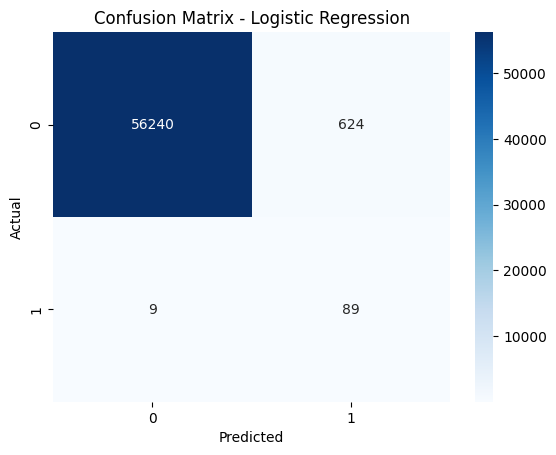

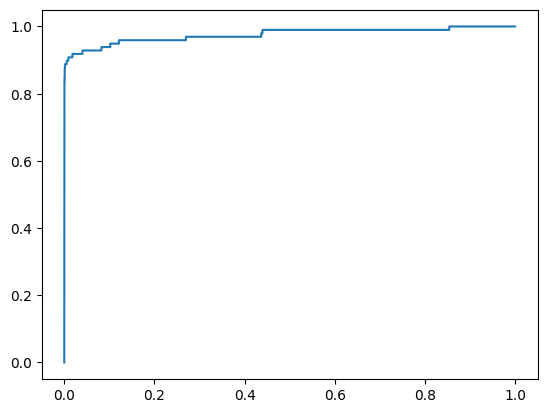

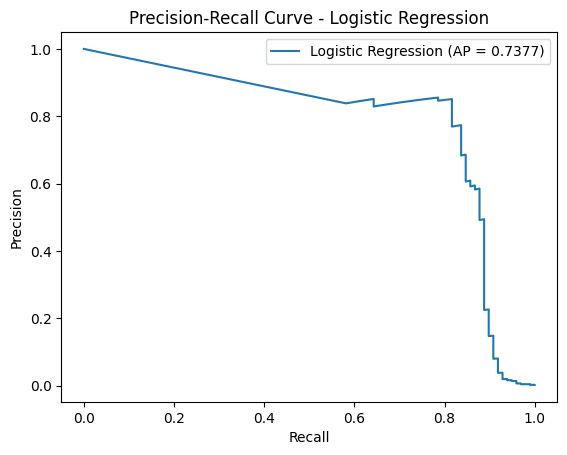

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8351    0.8265    0.8308        98

    accuracy                         0.9994     56962
   macro avg     0.9174    0.9131    0.9152     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC AUC Score: 0.9638
Average Precision Score (PR AUC): 0.8678


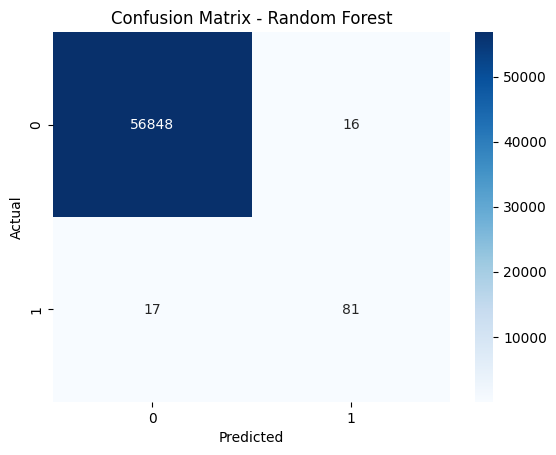

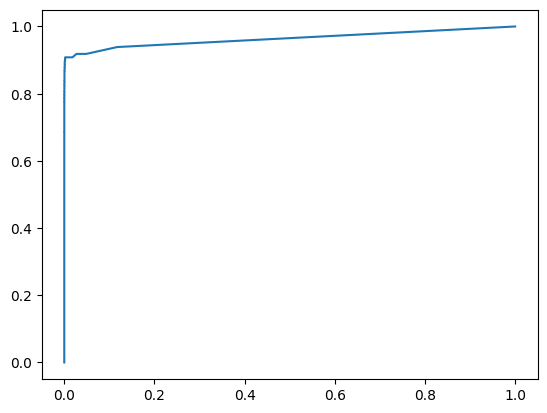

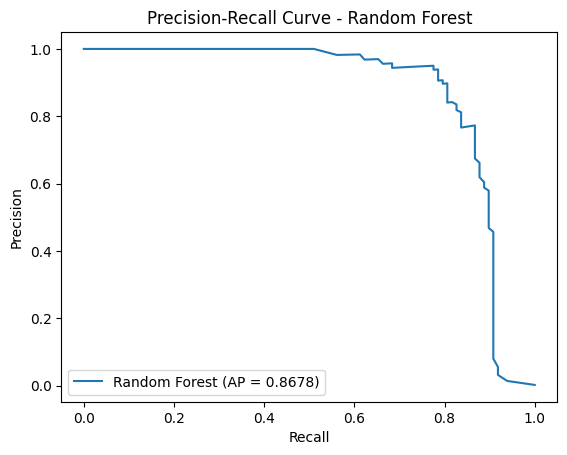

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0     0.9997    0.9996    0.9997     56864
           1     0.7905    0.8469    0.8177        98

    accuracy                         0.9994     56962
   macro avg     0.8951    0.9233    0.9087     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC AUC Score: 0.9831
Average Precision Score (PR AUC): 0.8671


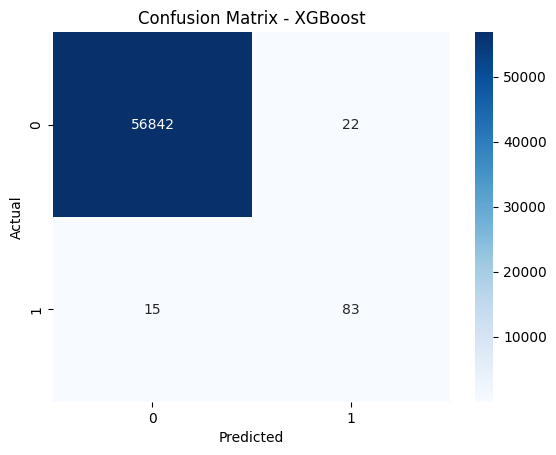

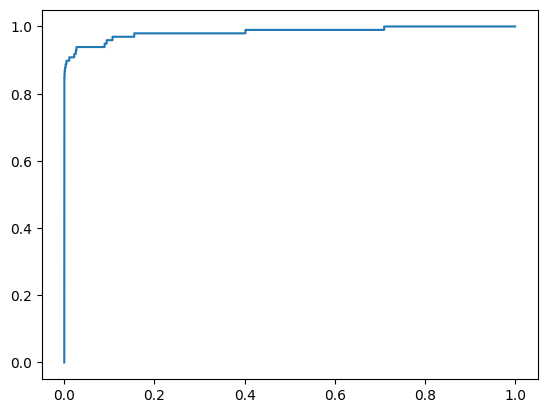

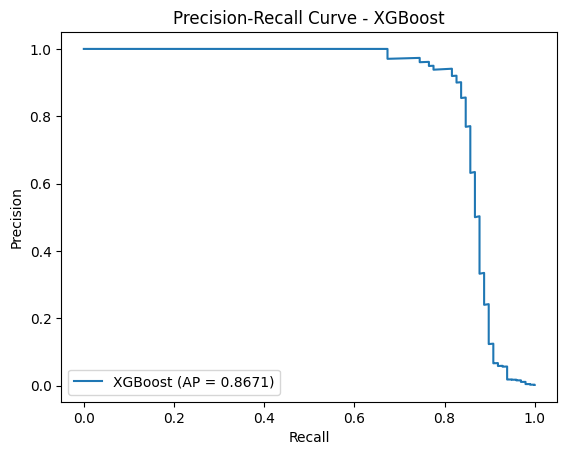

In [16]:
evaluate_model(lr, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")